# Skyrmion in a disk

In this tutorial, we compute and relax a skyrmion in an interfacial-DMI material in a confined disk like geometry.

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm

We define mesh in cuboid through corner points `p1` and `p2`, and discretisation cell size `cell`.

In [2]:
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

The mesh we defined is:

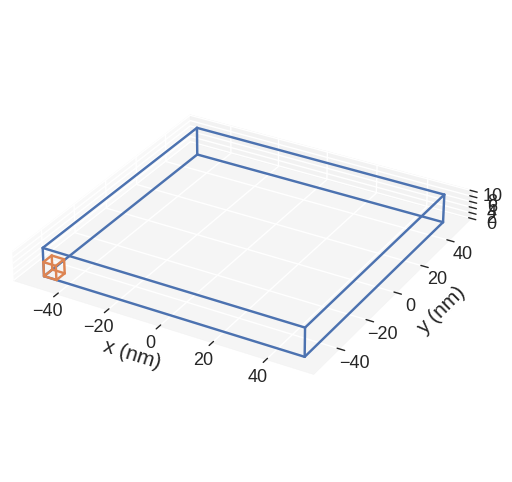

In [3]:
mesh.mpl()

Now, we can define the system object by first setting up the Hamiltonian:

In [4]:
system = mm.System(name='skyrmion')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='Cnv_z') 
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 2e5)))

Disk geometry is set up by defining the saturation magnetisation (norm of the magnetisation field). For that, we define a function:

In [5]:
Ms = 1.1e6

def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape, 
    Ms inside cylinder.
    
    Cylinder radius is 50nm.
    
    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 50e-9:
        return Ms
    else:
        return 0

And the second function we need is the function to define the initial magnetisation which is going to relax to skyrmion.

In [6]:
def m_init(pos):
    """Function to set initial magnetisation direction: 
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.
    
    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms_fun, valid='norm')

The geometry is now cylindrical:

In [7]:
system.m.norm.hv(kdims=['x', 'y'])

:DynamicMap   [z]
   :Image   [x,y]   (field)

and the initial magnetsation is:

/home/zulfigak/anaconda3/envs/ubermagdev_try/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/zulfigak/anaconda3/envs/ubermagdev_try/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


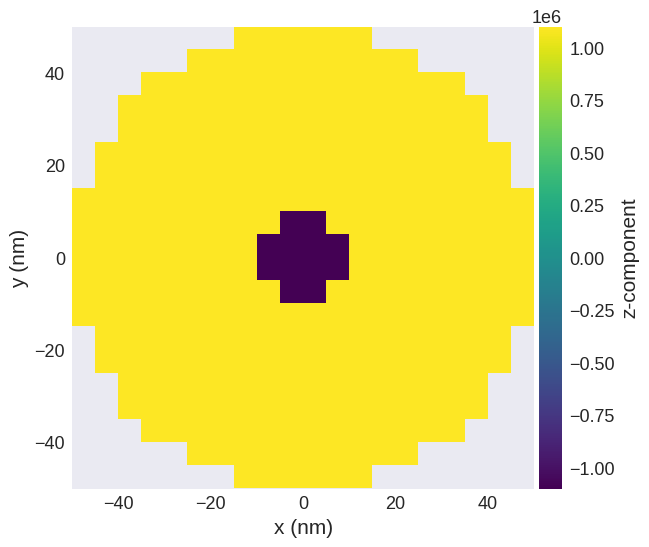

In [8]:
system.m.sel('z').mpl()

Finally we can minimise the energy and plot the magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/11/10 15:56]... (0.4 s)


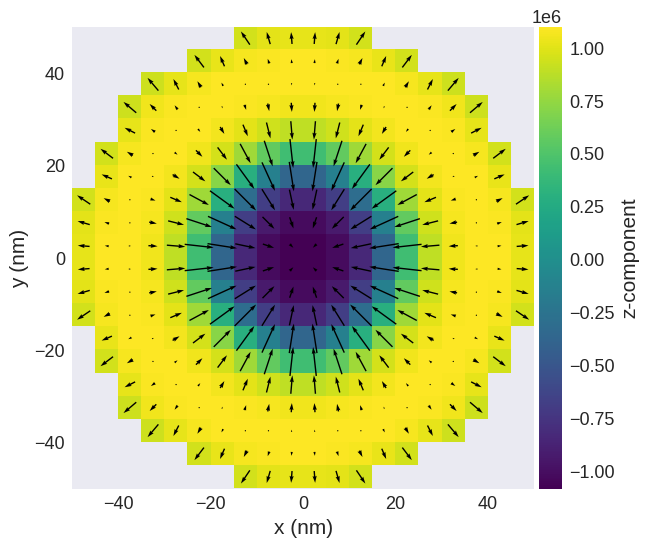

In [9]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel('z').mpl()

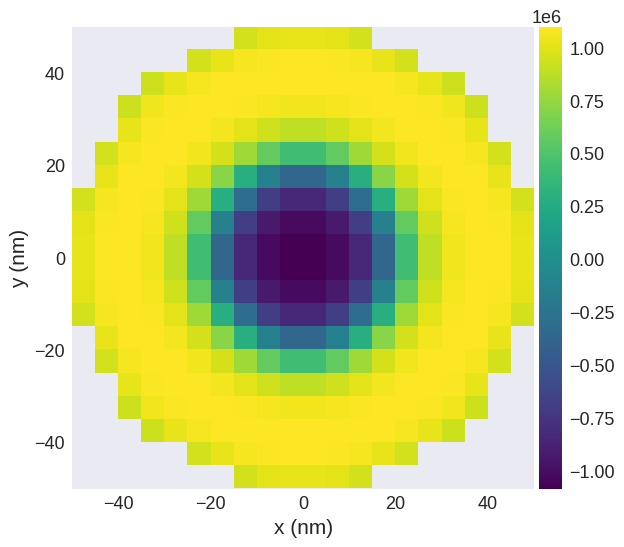

In [10]:
# Plot z-component only:
system.m.z.sel('z').mpl()

In [11]:
system.m.hv(kdims=['x', 'y'])

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

Finally we can sample and plot the magnetisation along the line:

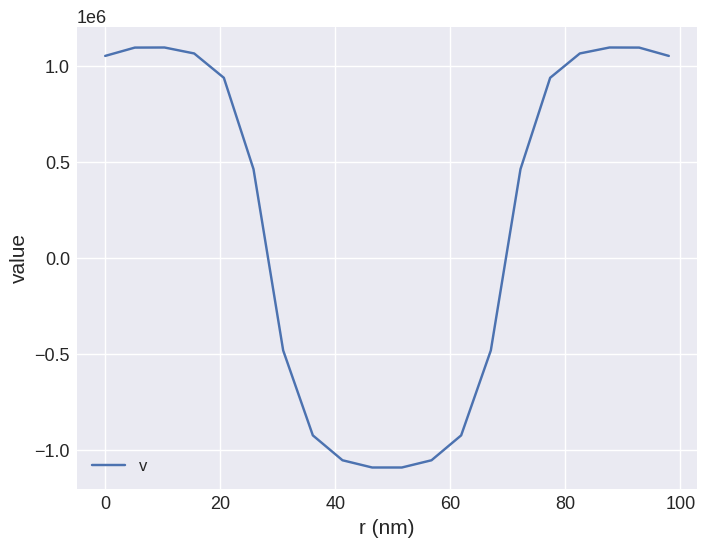

In [12]:
system.m.z.line(p1=(-49e-9, 0, 0), p2=(49e-9, 0, 0), n=20).mpl()